
# Project 1 — Parts c)–f)
This notebook solves **c, d, e, f**. 


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (new variables added on as they are introduced) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
LAM  = 1e-4   # from part b
#LAM = 1      # Bigger lambda to see convergence in plots ? --- IGNORE ---
BETA = 0.3   # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 1000     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

Xtr, Xte = X_tr_s[:, :P_FIXED], X_te_s[:, :P_FIXED]
p = Xtr.shape[1]
theta0 = np.zeros(p)



## c) Gradient Descent for OLS and Ridge (using `grad.py`)

We first use the plain gradient descent method and compare it to close form OLS and Ridge. This is based off an example from the lecture notes, week 37, Gradient Descent Example. 


In [33]:
# ---- closed forms and metrics ----
from Code.models  import fit_ols, fit_ridge, predict_centered
from Code.metrics import mse, r2
from Code.grad   import loss_ridge, loss_ols

n, p = Xtr.shape
XT_X_tr = Xtr.T @ Xtr

theta_cf_ols   = fit_ols(Xtr, y_tr_c)                  # solves (X^T X)θ = X^T y_c
theta_cf_ridge = fit_ridge(Xtr, y_tr_c, lam=LAM, n_factor=True)  # solves (X^T X + λ I)θ = X^T y_c

# ---- Hessians  ----
# OLS objective: (1/2n)||Xθ - y_c||^2  ⇒ H = (X^T X)/n
# Ridge objective (λ-form): (1/2n)||Xθ - y_c||^2 + (λ/2)||θ||^2  ⇒ H = (X^T X)/n + λ I
H_ols   = XT_X_tr / n
H_ridge = XT_X_tr / n + LAM * np.eye(p)

# Safe steps, based on largest Hessian eigenvalue
L_ols   = np.linalg.eigvalsh(H_ols).max()
L_ridge = np.linalg.eigvalsh(H_ridge).max()
eta_ols   = 1.0 / L_ols
eta_ridge = 1.0 / L_ridge

# Small-but-reasonable iteration budgets for a quick demo (to get close to CF we need more (probably millions), but the code will never finish)
N_ols, N_ridge = 20_000, 20_000  # increase if we want them closer to CF

# ---- plain GD loops (λ-form) ----
def gd_full(X, y_c, lam, eta, iters):
    n, p = X.shape
    th = np.zeros(p)
    for _ in range(iters): # could add a tol-based stopping criterion
        r = X @ th - y_c
        grad = (X.T @ r)/n + lam * th
        th  -= eta * grad
    return th

theta_gd_ols   = gd_full(Xtr, y_tr_c, lam=0.0,  eta=eta_ols,   iters=N_ols)
theta_gd_ridge = gd_full(Xtr, y_tr_c, lam=LAM, eta=eta_ridge, iters=N_ridge)

# ---- test metrics (on original y-scale) ----
yhat_cf_ols   = predict_centered(Xte, theta_cf_ols,   y_mean)
yhat_gd_ols   = predict_centered(Xte, theta_gd_ols,   y_mean)
yhat_cf_ridge = predict_centered(Xte, theta_cf_ridge, y_mean)
yhat_gd_ridge = predict_centered(Xte, theta_gd_ridge, y_mean)

print("OLS   | CF  MSE/R2:", mse(y_te, yhat_cf_ols),   r2(y_te, yhat_cf_ols))
print("OLS   | GD  MSE/R2:", mse(y_te, yhat_gd_ols),   r2(y_te, yhat_gd_ols))
print("Ridge | CF  MSE/R2:", mse(y_te, yhat_cf_ridge), r2(y_te, yhat_cf_ridge))
print("Ridge | GD  MSE/R2:", mse(y_te, yhat_gd_ridge), r2(y_te, yhat_gd_ridge))

print("Ridge TRAIN | CF:", loss_ridge(Xtr, y_tr_c, theta_cf_ridge, LAM, True),
      " GD:",           loss_ridge(Xtr, y_tr_c, theta_gd_ridge,   LAM, True))

print("OLS TRAIN | CF:", loss_ols(Xtr, y_tr_c, theta_cf_ols),
      " GD:",           loss_ols(Xtr, y_tr_c, theta_gd_ols))


OLS   | CF  MSE/R2: 0.1351492510020802 0.32147733207080154
OLS   | GD  MSE/R2: 0.13157938981980613 0.33939997474601846
Ridge | CF  MSE/R2: 0.12625328341116895 0.36613992264264184
Ridge | GD  MSE/R2: 0.13217029593648208 0.33643330499528123
Ridge TRAIN | CF: 0.04251260724044948  GD: 0.045991068261716436
OLS TRAIN | CF: 0.04014885485646233  GD: 0.04587079678167183



## d) Optimizers: Momentum, AdaGrad, RMSProp, Adam

We keep the same objectives but change the update rule. We'll use both Ridge and OLS. We plot MSE and R^2 for all the optimizers, and also a training loss plot.  



 TEST metrics by optimizer (OLS)
gd         MSE=0.132044  R²=0.3371
momentum   MSE=0.132831  R²=0.3331
adagrad    MSE=0.137117  R²=0.3116
rmsprop    MSE=0.130348  R²=0.3456
adam       MSE=0.128056  R²=0.3571

 TEST metrics by optimizer (Ridge)
gd         MSE=0.131033  R²=0.3421
momentum   MSE=0.131375  R²=0.3404
adagrad    MSE=0.137484  R²=0.3098
rmsprop    MSE=0.131679  R²=0.3389
adam       MSE=0.130480  R²=0.3449


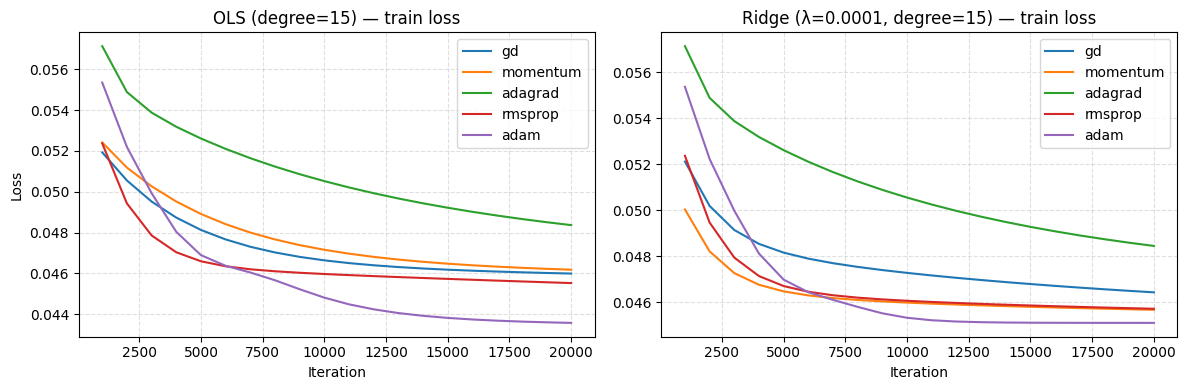

In [ ]:
# ---- various optimizers ----

# near-optimal ridge step (helps plain GD/momentum on ridge)
eigs_data = np.linalg.eigvalsh(XT_X_tr / n)
e_min, e_max = eigs_data[0], eigs_data[-1]
ETA_RIDGE_OPT = 2.0 / ((e_max + LAM) + (e_min + LAM))  # = 2/(L+mu) for ridge quad

LOG_EVERY = 1000 # log train loss every this many iters

# Optimizer loop (λ-form objective)
def run_optimizer_lambda(
    X, y_c, lam, *, optimizer="gd", eta=1e-3, iters=20_000,
    beta=BETA, rho=RHO, b1=B1, b2=B2, eps=EPS, log_every=LOG_EVERY
):
    """
    One-loop trainer on the λ-form objective:
      J(θ) = (1/(2n))||Xθ - y_c||^2 + (λ/2)||θ||^2
    Returns (theta, steps, losses) with losses logged every `log_every` iters.
    """
    n, p = X.shape
    th = np.zeros(p)
    v  = np.zeros_like(th)  # momentum velocity
    s  = np.zeros_like(th)  # 2nd moment (AdaGrad/RMSProp/Adam)
    m  = np.zeros_like(th)  # 1st moment (Adam)

    
    steps, losses = [], []
    for k in range(1, iters + 1): 
        r = X @ th - y_c
        g = (X.T @ r) / n + lam * th  # λ-form gradient
        
        if optimizer == "gd":
            th -= eta * g
        elif optimizer == "momentum":
            v  = beta * v + (1 - beta) * g
            th -= eta * v
        elif optimizer == "adagrad":
            s += g * g
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "rmsprop":
            s  = rho * s + (1 - rho) * (g * g)
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "adam":
            m  = b1 * m + (1 - b1) * g
            s  = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**k)
            s_hat = s / (1 - b2**k)
            th -= eta * m_hat / (np.sqrt(s_hat) + eps)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")
        
        #log train loss
        if (k % log_every) == 0:
            L = loss_ols(X, y_c, th) if lam == 0.0 else loss_ridge(X, y_c, th, lam, n_factor=True) 
            steps.append(k); losses.append(float(L)) 

    return th, np.array(steps), np.array(losses)

# iteration budgets
iters_ols, iters_ridge = N_ols, N_ridge

"""learning-rate choices: 
curvature-aware for GD/momentum; eta_ols based on largest Hessian eigenvalue calculated in c). 
conservative bases for adaptives (AdaGrad/RMSProp/Adam): smaller base eta, too large eta can blow up. 
 """
configs = {
    "gd":       {"ols_eta": 0.8 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT},
    "momentum": {"ols_eta": 0.6 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT, "beta": BETA},
    "adagrad":  {"ols_eta": 1e-2,            "ridge_eta": 1e-2},
    "rmsprop":  {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "rho": RHO},
    "adam":     {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "b1": B1, "b2": B2, "eps": EPS},
}


rows_ols, rows_ridge = [], [] # for test metrics
curves_ols, curves_ridge = {}, {} # for loss curves

# Run all optimizers
for name, hp in configs.items():
    # OLS
    th_o, st_o, ls_o = run_optimizer_lambda(
        Xtr, y_tr_c, lam=0.0, optimizer=name,
        eta=hp["ols_eta"], iters=iters_ols,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS)
    )
    yhat_o = predict_centered(Xte, th_o, y_mean)
    rows_ols.append((name, mse(y_te, yhat_o), r2(y_te, yhat_o)))
    curves_ols[name] = (st_o, ls_o)

    # Ridge
    th_r, st_r, ls_r = run_optimizer_lambda(
        Xtr, y_tr_c, lam=LAM, optimizer=name,
        eta=hp["ridge_eta"], iters=iters_ridge,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS)
    )
    yhat_r = predict_centered(Xte, th_r, y_mean)
    rows_ridge.append((name, mse(y_te, yhat_r), r2(y_te, yhat_r)))
    curves_ridge[name] = (st_r, ls_r)

print("\n TEST metrics by optimizer (OLS)")
for name, m, r in rows_ols:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

print("\n TEST metrics by optimizer (Ridge)")
for name, m, r in rows_ridge:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

# ---------- loss curves ----------
Lref_ols   = loss_ols(Xtr, y_tr_c, theta_cf_ols)
Lref_ridge = loss_ridge(Xtr, y_tr_c, theta_cf_ridge, LAM, n_factor=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# OLS
for name, (steps, losses) in curves_ols.items():
    if losses.size:
        axes[0].plot(steps, losses, label=name)
axes[0].set_title(f"OLS (degree={p}) — train loss"); axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss")
axes[0].grid(True, ls="--", alpha=0.4); axes[0].legend()

# Ridge
for name, (steps, losses) in curves_ridge.items():
    if losses.size:
        axes[1].plot(steps, losses, label=name)
axes[1].set_title(f"Ridge (λ={LAM:g}, degree={p}) — train loss"); axes[1].set_xlabel("Iteration")
axes[1].grid(True, ls="--", alpha=0.4); axes[1].legend()

savepath = fig_dir / "Part_c_d_e_f_GD_optimizers_loss_curves.png"
fig.savefig(savepath, dpi=150)
fig.tight_layout(); plt.show()



## e) LASSO 

GD Lasso vs Scikit Lasso. 



In [35]:
from Code.models import lasso_gradient, fit_lasso_skl

# train
theta_gd_l1 = lasso_gradient(Xtr, y_tr_c, lam=LAM, iters=8000, eta=1e-3, theta0=None)
theta_skl = fit_lasso_skl(Xtr, y_tr_c, lam=LAM)

# predict
yhat_gd_l1 = Xte @ theta_gd_l1 + y_mean
yhat_skl = Xte @ theta_skl + y_mean

print("LASSO Gradient — Test MSE/R²:",
      mse(y_te, yhat_gd_l1), r2(y_te, yhat_gd_l1))

print("SKL  MSE/R²:", mse(y_te, yhat_skl), r2(y_te, yhat_skl))


LASSO Gradient — Test MSE/R²: 0.15203586691752013 0.23669734551309862
SKL  MSE/R²: 0.12913859860045612 0.351654072772696


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+00, tolerance: 4.234e-05
  model = cd_fast.enet_coordinate_descent(


We add the optimizers from part d). 

In [36]:
import numpy as np

def lasso_grad_opt(
    X, y_c, lam,
    iters=5000, eta=1e-3,
    optimizer="sgd",      # "sgd" | "momentum" | "adagrad" | "rmsprop" | "adam"
    beta=BETA,             # momentum factor (momentum, adam)
    rho=RHO,             # rmsprop decay
    b1=B1, b2=B2,     # adam moments
    eps=EPS,             # numerical eps for adaptive methods
    theta0=None
):
    """
    Subgradient descent for LASSO with simple optimizers.
    Minimizes: (1/n)||Xθ - y_c||^2 + lam*||θ||_1
    """
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else np.asarray(theta0, float).copy()

    # states
    v = np.zeros_like(theta)  # momentum
    s = np.zeros_like(theta)  # adagrad/rmsprop/adam (2nd moment)
    m = np.zeros_like(theta)  # adam (1st moment)
    t = 0

    for _ in range(iters):
        # smooth part gradient
        r = X @ theta - y_c
        g_smooth = (2.0/n) * (X.T @ r)

        # subgradient of L1 (sign(0)=0)
        g_l1 = lam * np.sign(theta)

        g = g_smooth + g_l1
        t += 1

        if optimizer == "sgd":
            theta -= eta * g

        elif optimizer == "momentum":
            v = beta * v + (1 - beta) * g
            theta -= eta * v

        elif optimizer == "adagrad":
            s += g * g
            theta -= (eta / (np.sqrt(s) + eps)) * g

        elif optimizer == "rmsprop":
            s = rho * s + (1 - rho) * (g * g)
            theta -= (eta / (np.sqrt(s) + eps)) * g

        elif optimizer == "adam":
            m = b1 * m + (1 - b1) * g
            s = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**t)
            s_hat = s / (1 - b2**t)
            theta -= eta * m_hat / (np.sqrt(s_hat) + eps)

        else:
            raise ValueError("Unknown optimizer")

    return theta


In [37]:
# Train (standardized X, centered y; no intercept)
opts = ["sgd", "momentum", "adagrad", "rmsprop", "adam"]
etas = {
    "sgd":      1e-3,
    "momentum": 1e-3,
    "adagrad":  5e-3,
    "rmsprop":  1e-3,
    "adam":     1e-3,
}
results = {}
for opt in opts:
    th = lasso_grad_opt(X_tr_s, y_tr_c, lam=LAM, iters=8000, eta=etas[opt], optimizer=opt)
    yhat = X_te_s @ th + y_mean
    results[opt] = (mse(y_te, yhat), r2(y_te, yhat))

for k,(mse_v,r2_v) in results.items():
    print(f"{k:8s}  MSE={mse_v:.6f}  R²={r2_v:.4f}")


sgd       MSE=0.152036  R²=0.2367
momentum  MSE=0.152036  R²=0.2367
adagrad   MSE=0.148984  R²=0.2520
rmsprop   MSE=0.132883  R²=0.3329
adam      MSE=0.131237  R²=0.3411



## f) Stochastic Gradient Descent

We test SGD on Ridge. We test with different batch sizes, and plot loss vs epochs for plain GD and SGD. We evaluate with MSE and $R^2$. 



Epochs:             1000
Steps per epoch:    4
Total updates:      4000
LR schedule:        constant
Ridge λ:            0.0001, degree p: 15

TEST metrics by optimizer (OLS, mini-batch)
sgd        MSE=0.142868  R²=0.2827
momentum   MSE=0.143477  R²=0.2797
adagrad    MSE=0.155100  R²=0.2213
rmsprop    MSE=0.146386  R²=0.2651
adam       MSE=0.146501  R²=0.2645

TEST metrics by optimizer (Ridge, mini-batch)
sgd        MSE=0.140808  R²=0.2931
momentum   MSE=0.139641  R²=0.2989
adagrad    MSE=0.155068  R²=0.2215
rmsprop    MSE=0.146255  R²=0.2657
adam       MSE=0.146678  R²=0.2636


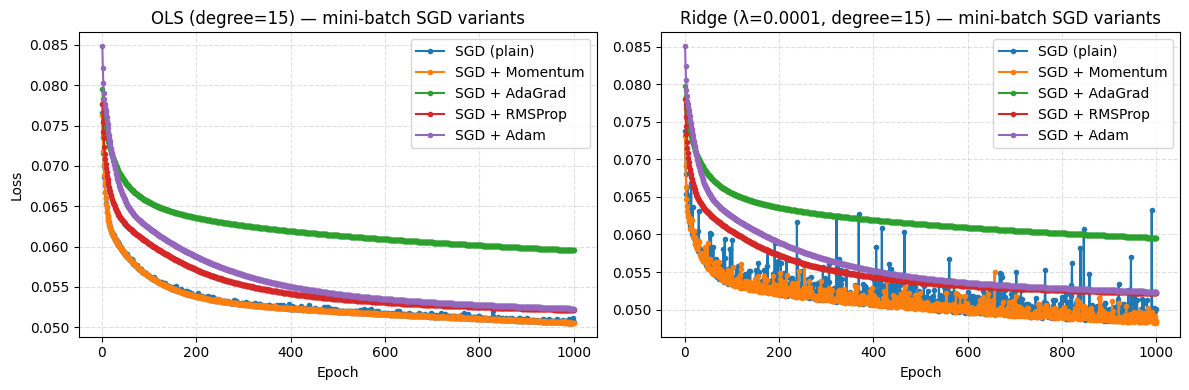

In [ ]:
# ---- SGD variants of all optimizers (mini-batch for everyone) + schedules + nice logging ----
from math import pi, cos

# ---------- helpers ----------
# Full loss: computes the training objective we're optimizing.
def full_loss(X, y_c, theta, lam):
    from Code.grad import loss_ols, loss_ridge
    return float(loss_ols(X, y_c, theta)) if lam == 0.0 else float(loss_ridge(X, y_c, theta, lam, n_factor=True)) #OLS or ridge, based on lambda value

# Exponential moving average,to smooth noisy curves
def ema(x, alpha=0.2):
    out, m = [], None
    for v in x:
        m = v if m is None else (1-alpha)*m + alpha*v
        out.append(m)
    return np.array(out)

# Learning rate schedules, to help with convergence
def lr_schedule(step, *, eta0, total_steps=None, kind="constant"):
    """Return a scale in [0, eta0] for the given step and schedule kind."""
    if kind == "constant" or total_steps is None: 
        return eta0                     #constant eta
    if kind == "invtime":               # η_t = η0 / (1 + t), decays over time
        return eta0 / (1.0 + step)
    if kind == "cosine":                # half-cosine from η0 → 0 over total_steps
        t = min(step, total_steps)
        return 0.5 * eta0 * (1 + cos(pi * t / total_steps)) 
    raise ValueError(f"Unknown schedule: {kind}")

# Find smallest/largest eigenvalues of X^TX/n. Helps GD/momentum on ridge quadratic. 
eigs_data = np.linalg.eigvalsh(XT_X_tr / n)
e_min, e_max = eigs_data[0], eigs_data[-1]
ETA_RIDGE_OPT = 2.0 / ((e_max + LAM) + (e_min + LAM))  # = 2/(L+mu)

# Mini-batch SGD loop (λ-form objective, OLS and Ridge), with various optimizers & schedules
def run_optimizer_lambda(
    X, y_c, lam, *, optimizer="sgd", eta=1e-3, epochs=25, batch_size=64,
    beta=BETA, rho=RHO, b1=B1, b2=B2, eps=EPS,
    schedule_kind="constant", rng=None, clip_grad=None, return_per_epoch=True
):
    """
    Mini-batch trainer for J(θ) = (1/2n)||Xθ-y||^2 + (λ/2)||θ||^2 (λ-form objective).
    - optimizer in {"sgd","momentum","adagrad","rmsprop","adam"}
    - schedule_kind in {"constant","invtime","cosine"}
    - returns (epochs_array, losses) if return_per_epoch else (steps_array, losses)
    """
    n, p = X.shape
    if rng is None:
        rng = np.random.default_rng(0)

    
    steps_per_epoch = int(np.ceil(n / batch_size))
    total_steps     = epochs * steps_per_epoch

    th = np.zeros(p)
    v  = np.zeros_like(th)  # momentum
    s  = np.zeros_like(th)  # 2nd moment (AdaGrad/RMSProp/Adam)
    m  = np.zeros_like(th)  # 1st moment (Adam)

    losses, xaxis = [], []
    step = 0
    # epoch loop
    for ep in range(1, epochs+1):
        perm = rng.permutation(n)
        for b in range(steps_per_epoch):
            step += 1
            lo, hi = b*batch_size, min((b+1)*batch_size, n)
            idx = perm[lo:hi]
            Xb, yb = X[idx], y_c[idx]
            nb = len(idx)

            # gradient (λ-form)
            g = (Xb.T @ (Xb @ th - yb))/nb + lam*th

            # optional gradient clipping
            if clip_grad is not None:
                gn = np.linalg.norm(g)
                if gn > clip_grad:
                    g *= (clip_grad / max(gn, 1e-12))

            # scheduled learning rate
            lr = lr_schedule(step, eta0=eta, total_steps=total_steps, kind=schedule_kind)

            # parameter update
            if optimizer == "sgd":
                th -= lr * g
            elif optimizer == "momentum":
                v  = beta*v + (1-beta)*g
                th -= lr * v
            elif optimizer == "adagrad":
                s += g*g
                th -= lr * g / (np.sqrt(s) + eps)
            elif optimizer == "rmsprop":
                s  = rho*s + (1-rho)*(g*g)
                th -= lr * g / (np.sqrt(s) + eps)
            elif optimizer == "adam":
                m  = b1*m + (1-b1)*g
                s  = b2*s + (1-b2)*(g*g)
                m_hat = m/(1-b1**step)
                s_hat = s/(1-b2**step)
                th -= lr * m_hat / (np.sqrt(s_hat) + eps)
            else:
                raise ValueError("unknown optimizer")

        # end-of-epoch clean log
        if return_per_epoch:
            losses.append(full_loss(X, y_c, th, lam))
            xaxis.append(ep)

    return th, np.array(xaxis), np.array(losses) 

# ----- SGD setup & reporting knobs -----
rng = np.random.default_rng(SEED_MB)
STEPS_PER_EP = int(np.ceil(n / BATCH_SIZE))
ITERS_SGD    = EPOCHS_MB * STEPS_PER_EP  # total parameter updates

# schedules switch between: "constant", "invtime", "cosine"
# schedule means how the learning rate changes over time
SCHED = "constant"

# learning-rate choices 
configs = {
    "sgd":      {"ols_eta0": 0.4 * eta_ols,      "ridge_eta0": 0.5 * ETA_RIDGE_OPT},
    "momentum": {"ols_eta0": 0.4 * eta_ols,      "ridge_eta0": 0.5 * ETA_RIDGE_OPT, "beta": BETA},
    "adagrad":  {"ols_eta0": 5e-3,               "ridge_eta0": 5e-3},
    "rmsprop":  {"ols_eta0": 1e-3,               "ridge_eta0": 1e-3, "rho": RHO},
    "adam":     {"ols_eta0": 1e-3,               "ridge_eta0": 1e-3, "b1": B1, "b2": B2, "eps": EPS},
}

# ----- run & collect -----
rows_ols, rows_ridge = [], []
curves_ols, curves_ridge = {}, {}

for name, hp in configs.items():
    # OLS (mini-batch)
    th_o, ep_o, ls_o = run_optimizer_lambda(
        Xtr, y_tr_c, lam=0.0, optimizer=name,
        eta=hp["ols_eta0"], epochs=EPOCHS_MB, batch_size=BATCH_SIZE,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        schedule_kind=SCHED, rng=rng, clip_grad=None, return_per_epoch=True
    )
    yhat_o = predict_centered(Xte, th_o, y_mean)
    rows_ols.append((name, mse(y_te, yhat_o), r2(y_te, yhat_o)))
    curves_ols[name] = (ep_o, ls_o)

    # Ridge (mini-batch)
    th_r, ep_r, ls_r = run_optimizer_lambda(
        Xtr, y_tr_c, lam=LAM, optimizer=name,
        eta=hp["ridge_eta0"], epochs=EPOCHS_MB, batch_size=BATCH_SIZE,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        schedule_kind=SCHED, rng=rng, clip_grad=None, return_per_epoch=True
    )
    yhat_r = predict_centered(Xte, th_r, y_mean)
    rows_ridge.append((name, mse(y_te, yhat_r), r2(y_te, yhat_r)))
    curves_ridge[name] = (ep_r, ls_r)

# ----- SGD config ----
print(f"Epochs:             {EPOCHS_MB}")
print(f"Steps per epoch:    {STEPS_PER_EP}")
print(f"Total updates:      {ITERS_SGD}")
print(f"LR schedule:        {SCHED}")
print(f"Ridge λ:            {LAM}, degree p: {p}")

print("\nTEST metrics by optimizer (OLS, mini-batch)")
for name, m, r in rows_ols:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

print("\nTEST metrics by optimizer (Ridge, mini-batch)")
for name, m, r in rows_ridge:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

# ---------- loss curves ----------
label_map = {
    "sgd": "SGD (plain)",
    "momentum": "SGD + Momentum",
    "adagrad": "SGD + AdaGrad",
    "rmsprop": "SGD + RMSProp",
    "adam": "SGD + Adam",
}
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for name, (epochs_arr, losses) in curves_ols.items():
    axes[0].plot(epochs_arr, losses, marker="o", ms=3, label=label_map.get(name, name))
axes[0].set_title(f"OLS (degree={p}) — mini-batch SGD variants")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].grid(True, ls="--", alpha=0.4); axes[0].legend()

for name, (epochs_arr, losses) in curves_ridge.items():
    axes[1].plot(epochs_arr, losses, marker="o", ms=3, label=label_map.get(name, name))
axes[1].set_title(f"Ridge (λ={LAM:g}, degree={p}) — mini-batch SGD variants")
axes[1].set_xlabel("Epoch")
axes[1].grid(True, ls="--", alpha=0.4); axes[1].legend()

savepath = fig_dir / "Part_f_SGD_all_optimizers_loss_curves.png"
fig.savefig(savepath, dpi=150)
fig.tight_layout(); plt.show()
